In [26]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict , Literal , Annotated
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage , HumanMessage
from pydantic import BaseModel , Field
import operator

In [27]:
llm1 = ChatOllama(model = 'llama3')
llm2 = ChatOllama(model = 'gemma3:4b')
llm3 = ChatOllama(model = 'llama3')

In [28]:
class StrSchema(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [29]:
str_llm = llm2.with_structured_output(StrSchema)

In [30]:
#state
class TweetState(TypedDict):
    tweet : str
    topic : str
    evaluation : Literal['approved' , 'needs_improvement']
    feedback : str
    iteration : str
    max_iteration : str

    feedback_history : Annotated[list[str] , operator.add]
    tweet_history : Annotated[list[str] , operator.add]

In [31]:
def generate_tweet(state : TweetState)->TweetState:
    #prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
        Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

        Rules:
        - Do NOT use question-answer format.
        - Max 280 characters.
        - Use observational humor, irony, sarcasm, or cultural references.
        - Think in meme logic, punchlines, or relatable takes.
        - Use simple, day to day english
        """)
            ]
    
    response = llm1.invoke(messages).content

    return {'tweet':response , 'tweet_history' : [response]}

In [32]:
def evaluate_tweet(state:TweetState)->TweetState:
    #prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
    
    response = str_llm.invoke(messages)

    return {'evaluation':response.evaluation , 'feedback':response.feedback , 'feedback_history' : [response.feedback]}

In [33]:
def optimize_tweet(state:TweetState):
    #prompt
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = llm3.invoke(messages).content

    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration , 'tweet_history' : [response]}

In [34]:
def route_cond(state : TweetState)-> Literal['approved' , 'needs_improvement']:
    if state['feedback'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [35]:
#graph
graph = StateGraph(TweetState)

graph.add_node('gen_tweet', generate_tweet)
graph.add_node('eval_tweet' , evaluate_tweet)
graph.add_node('optimize_tweet' , optimize_tweet)

graph.add_edge(START , 'gen_tweet')
graph.add_edge('gen_tweet' , 'eval_tweet')
graph.add_conditional_edges('eval_tweet' , route_cond , {'approved' : END , 'needs_improvement' : 'optimize_tweet'})
graph.add_edge('optimize_tweet' , 'eval_tweet')

workflow = graph.compile()

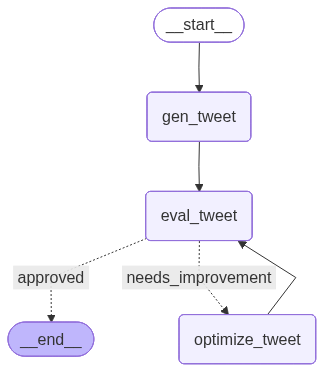

In [36]:
workflow

In [37]:
initial_state = {
    "topic": "AI Race",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [38]:
result

{'tweet': 'Here\'s a rewritten tweet:\n\n"AI: Tax master Water wizard Not saying AI is bad at everything... #AIProbs"\n\nThis tweet aims to be more concise and punchy while still conveying the humorous contrast between AI\'s mastery of complex tasks (taxes) and its failure in something as simple as boiling water. The hashtags add a touch of humor and keep the tone lighthearted, making it more likely to go viral.',
 'topic': 'AI Race',
 'evaluation': 'needs_improvement',
 'feedback': 'This tweet is fundamentally flawed. The core concept – AI’s supposed mastery of complex tasks juxtaposed with its inability to boil water – is a well-worn and frankly tired joke. The rewritten tweet itself is clunky and self-referential, failing to deliver any genuine humor. It reads like a meta-commentary on internet trends rather than a standalone joke. The formatting is acceptable within the character limit, but the lack of originality and the somewhat forced phrasing seriously undermine its potential. 

In [39]:
for tweet in result['tweet_history']:
    print(tweet)

"Just watched the AI race and I'm not saying humans are obsolete, but I saw a neural network do my taxes better than me. Now I just need an AI to make me breakfast #AIIsTheFuture #Adulting Fail"
Here's a rewritten tweet that addresses the feedback:

"I'm not obsolete yet, but my taxes are thanks to AI. Meanwhile, I'm still struggling to make a decent bowl of oatmeal Who knew AI would be the ultimate breakfast coach? #AIIsTheFuture"

This revised tweet aims to add a more specific and surprising element by highlighting the contrast between AI's excelence in taxes and human's inability to even cook a simple breakfast. The joke relies on a relatable scenario, making it more engaging and likely to go viral.
Here's a rewritten tweet that incorporates the feedback:

"AI crushes taxes AI can't even scramble eggs Meanwhile, I'm over here burning water #AIIsTheFuture"

This revised tweet aims to be shorter, punchier, and more relatable. By highlighting the absurdity of AI excelling in one area (

In [40]:
for feedback in result['feedback_history']:
    print(feedback)

This tweet treads familiar territory – the anxiety about AI replacing humans – and leans heavily into a somewhat predictable ‘adulting fails’ framing. While the core concept of an AI doing taxes better than a human is mildly relatable, the punchline feels forced and relies on a cliché. The hashtag usage is fine, but ‘#AIIsTheFuture’ is massively overused. The final line, ‘Adulting Fail,’ actively weakens the potential humor, feeling like a tacked-on, uninspired conclusion. To improve, the tweet needs a more specific, surprising element to elevate it beyond the surface-level concern about AI dominance. It needs to feel less like a rehashing of a known idea and more like a genuinely clever observation.
This tweet attempts a clever juxtaposition, but ultimately falls flat. The explanation of the tweet itself is overly verbose and self-referential, immediately detracting from any potential humor. While the premise – AI handling taxes and a person failing at breakfast – has a sliver of pote